

# Machine Learning - Semestral Project
## by Jah'Podi Pôneis

## Requirements

These are the Python modules versions that we are going to be using in this notebook:

In [ ]:
pip install matminer==0.9.0

In [ ]:
pip install mendeleev==0.15.0

In [ ]:
pip install pymatgen==2023.12.18

In [ ]:
pip install scikit-learn==1.2.2

## Introduction

The objective of this project is to use ML strategies to predict the band gap value of materials using 2 different sets of features:

- Utilizing only the molar proportion of the materials as features
- Utilizing the molar proportion multiplied by each element respective electronegativity value as features

We wanted to know if adding the electronegativity value of the atoms that make up each material would give us a better prediction than just the molar proportion. This motivation is explained in more detail in the `README.

In order to do this, we will use the `expt_gap` dataset from `matminer`, which contains the band gap value of several materials. However, we will need to make some modifications to the dataset, so that we have the 2 cases of features mentioned above.

Next, we will train 4 models for each case: linear regression and random forest, both with and without reduction of dimensionality by PCA. At the end of this notebook, we present a discussion about the results obtained and analysis of the initial hypotheses.


Here are some constants used during the entire notebook:

In [10]:
TEST_SIZE = 0.1
SEED = 7530
FOLD_NUM = 10
ITER_NUM = 20

### Imports


 Here are all the imports that will be used throughout the notebook.


In [9]:
import matplotlib.pyplot as plt

import numpy as np

from pymatgen.core import Composition

from mendeleev import element

from matminer.datasets import load_dataset

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MaxAbsScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

## Dataset Pre-Processing

Standing out in scientific and materials engineering contexts, `matminer` is an essential Python library for working with data in the materials area, offering large datasets to be explored.

First of all, we'll remove the columns that will not be used from the `df` dataframe, and remove the rows with value `Nan`.

In [11]:
df = load_dataset("expt_gap")

df = df.dropna()

df

,formula,gap expt
0,Hg0.7Cd0.3Te,0.35
1,CuBr,3.08
2,LuP,1.30
3,Cu3SbSe4,0.40
4,ZnO,3.44
...,...,...
6349,Tm2MgTl,0.00
6350,Nb5Ga4,0.00
6351,Tb2Sb5,0.00
6352,Lu2AlTc,0.00


To train our models, we'll need to extract the molar proportions of the strings in the dataset. To perform this parsing, we'll use the function `Composition` from `pymatgen.core`, in order to transform the strings into dictionaries, in which the keys are going to be the elements and the values are going to be the molar proportion.

Utilizando a função `Composition` do módulo `pymatgen.core`, vamos criar uma lista de dicicionários, `lista_dict`, em que cada chave desses dicionários são os elementos que compõem o material e seus valores são a respectiva proporção molar.

In [12]:
dict_list = []

for string in df['formula']:
    composition = Composition(string)
    composition_dict = composition.as_dict()
    dict_list.append(composition_dict)

Visualizing this list:

In [14]:
print(dict_list[0:3])

[{'Hg': 0.7, 'Cd': 0.3, 'Te': 1.0}, {'Cu': 1.0, 'Br': 1.0}, {'Lu': 1.0, 'P': 1.0}]


Now, we will create a column for each chemical element that was used in the materials in the dataset, initially containing only values equal to zero

In [15]:
for dictionary in dict_list:
    for key in dictionary:
        df[key] = np.zeros(len(dict_list))

Following, we will add the molar proportion values to the new columns created in `df`. To avoid overwriting problems, we will use the `df.loc` method of `pandas`, which avoids this problem.

In [16]:
for ind, dictionary in enumerate(dict_list):
    for key in dictionary:
        df.loc[ind, key] = dictionary[key]

df = df.dropna()

df = df.drop('G0+', axis=1)

df

,formula,gap expt,Hg,Cd,Te,Cu,Br,Lu,P,Sb,...,Co,Nd,Ho,C,Rh,Ni,Tc,Re,Pm,Xe
0,Hg0.7Cd0.3Te,0.35,0.7,0.3,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CuBr,3.08,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,LuP,1.30,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Cu3SbSe4,0.40,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ZnO,3.44,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6349,Tm2MgTl,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6350,Nb5Ga4,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6351,Tb2Sb5,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6352,Lu2AlTc,0.00,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


The next step is to create the columns that will contain the molar proportion multiplied by the electronegativity value of each atom. First, we will create a list, `element_list`, with all the chemical elements present in the dataset.

In [17]:
element_list = []

for column in df:
    element_list.append(column)

element_list.remove('formula')
element_list.remove('gap expt')

Visualizing this list:

In [18]:
print(element_list[0:10])

['Hg', 'Cd', 'Te', 'Cu', 'Br', 'Lu', 'P', 'Sb', 'Se', 'Zn']


Next, we use another powerful libraries to obtain the electronegativity property of the elements. For this, we use the `mendeleev` library, that contains information from Pauling's Electronegativity, which is a scale that assigns numerical values to the atoms electronegativity. The higher the electronegativity value of an atom, the greater its affinity for electrons.

Next, we will create a list, `en_list`, that contains the electronegativity values of each atom, with the `element.en_pauling` method of the `element` object of the `mendeleev` module.

In [19]:
en_list = [element(elem).en_pauling for elem in element_list]

en_list[79] = 1.13
en_list[47] = 1.2
en_list[48] = 1.1
en_list[57] = 1.2

 The elements `Eu`, `Pm`, `Yb` and `Tb` had an electronegativity value of `None` according to the `mendeleev` module, but we searched Wikipedia for their respective values and added them manually.

 For this, we create a dictionary, `en_dict`, that joins the two lists above, with the key being a chemical element and its respective electronegativity value on the Pauling scale.

In [22]:
en_dict = {}

for i in range(len(element_list)):
    en_dict.update({element_list[i]:en_list[i]})

print(en_dict)

{'Hg': 1.9, 'Cd': 1.69, 'Te': 2.1, 'Cu': 1.9, 'Br': 2.96, 'Lu': 1.0, 'P': 2.19, 'Sb': 2.05, 'Se': 2.55, 'Zn': 1.65, 'O': 3.44, 'Pt': 2.2, 'In': 1.78, 'S': 2.58, 'K': 0.82, 'Sn': 1.96, 'Ce': 1.12, 'Pb': 1.8, 'B': 2.04, 'Cr': 1.66, 'Sr': 0.95, 'Be': 1.57, 'Nb': 1.6, 'Pr': 1.13, 'As': 2.18, 'Ba': 0.89, 'Ga': 1.81, 'Ge': 2.01, 'Ag': 1.93, 'Rb': 0.82, 'Th': 1.3, 'Tl': 1.8, 'Al': 1.61, 'Bi': 1.9, 'Au': 2.4, 'Cs': 0.79, 'H': 2.2, 'Si': 1.9, 'N': 3.04, 'Gd': 1.2, 'Sc': 1.36, 'Mn': 1.55, 'La': 1.1, 'F': 3.98, 'Cl': 3.16, 'I': 2.66, 'W': 1.7, 'Eu': 1.2, 'Yb': 1.1, 'Tm': 1.25, 'Sm': 1.17, 'Na': 0.93, 'Mo': 2.16, 'V': 1.63, 'U': 1.7, 'Ta': 1.5, 'Pd': 2.2, 'Tb': 1.2, 'Ca': 1.0, 'Zr': 1.33, 'Er': 1.24, 'Hf': 1.3, 'Y': 1.22, 'Mg': 1.31, 'Li': 0.98, 'Os': 2.2, 'Ru': 2.2, 'Ti': 1.54, 'Fe': 1.83, 'Dy': 1.22, 'Ir': 2.2, 'Co': 1.88, 'Nd': 1.14, 'Ho': 1.23, 'C': 2.55, 'Rh': 2.28, 'Ni': 1.91, 'Tc': 2.1, 'Re': 1.9, 'Pm': 1.13, 'Xe': 2.6}


Finally, we will create the columns that contain the molar proportion of the material multiplied by the electronegativity value of each atom in its structure.

In [23]:
for column in df:
    if column != 'formula' and column != 'gap expt':
        df[f'{column}_en'] = df[column] * en_dict[column]

df

,formula,gap expt,Hg,Cd,Te,Cu,Br,Lu,P,Sb,...,Co_en,Nd_en,Ho_en,C_en,Rh_en,Ni_en,Tc_en,Re_en,Pm_en,Xe_en
0,Hg0.7Cd0.3Te,0.35,0.7,0.3,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CuBr,3.08,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,LuP,1.30,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Cu3SbSe4,0.40,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ZnO,3.44,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6349,Tm2MgTl,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6350,Nb5Ga4,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6351,Tb2Sb5,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6352,Lu2AlTc,0.00,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.1,0.0,0.0,0.0


 We will now separate the two sets of features that will be used in Cases 1 and 2: `FEATURE1` contains only the molar proportion of the material, and `FEATURE2` contains the molar proportion multiplied by the electronegativity, as well as the `TARGET`, which will be the conductivity value of each material, `sigma [S/cm]`.

In [25]:
FEATURES1 = element_list
FEATURES2 = [f'{elem}_en' for elem in element_list]
TARGET = ['gap expt']

## Case 1

  In this case we will only use the molar proportion of the materials as features. All variables in this section will contain 1 at the end, to facilitate the differentiation of the variables of Case 2, which will be different only because of the different features.

  All models will use normalization by the absolute maximum of the features, both in case 1 and case 2, to standardize the molar proportion in both cases.

### Train-Test Split

  Performing the train and test split with `TEST_SIZE=0.1`.

In [27]:
df1 = df.copy()

df1 = df1.reindex(FEATURES1 + TARGET, axis=1)
df1 = df1.dropna()

x1 = df1.reindex(FEATURES1, axis=1)
y1 = df1.reindex(TARGET, axis=1)

x1 = x1.values
y1 = y1.values.ravel()

x_train1, x_test1, y_train1, y_test1 = train_test_split(
    x1, y1, test_size=TEST_SIZE, random_state=SEED
)

### Baseline

To get an idea if our models are acceptable, we will use the baseline model, `dummy1`, which will simply predict the mean of the conductivity values of the training data.

In [30]:
dummy1 = make_pipeline(
    MaxAbsScaler(),
    DummyRegressor(),
)

dummy1.fit(x_train1, y_train1)
y_dummy1 = dummy1.predict(x_test1)
rmse_dummy1 = mean_squared_error(y_dummy1, y_test1, squared=False)

print(f'The RMSE of the baseline model was: {rmse_dummy1:.3f}')

The RMSE of the baseline model was: 1.708


### PCA

First, we will perform PCA on the `x1` data to reduce the dimensionality of the problem, keeping 90% of the variance of the original dataset.

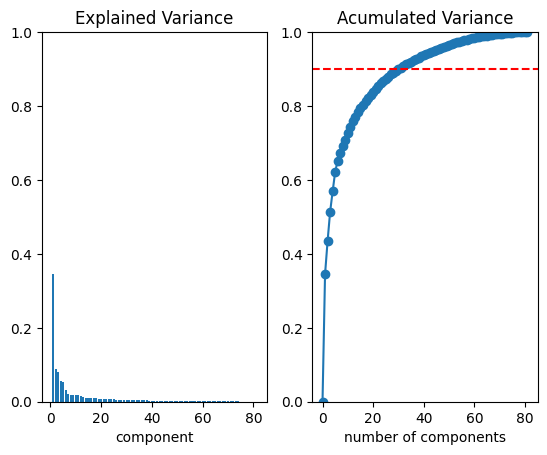

In [36]:
pca1 = PCA()

pca1.fit(x1)

explained_var1 = pca1.explained_variance_ratio_
cv1 = np.cumsum(explained_var1)
id_components1 = np.arange(1, pca1.n_components_ + 1)

fig1, axis1 = plt.subplots(1, 2)

axis1[0].bar(id_components1, explained_var1)
axis1[0].set(xlabel="component", title="Explained Variance", ylim=(0.0, 1.0))

axis1[1].plot(np.r_[0, id_components1], np.r_[0, cv1], marker="o")
axis1[1].set(
    xlabel="number of components",
    title="Acumulated Variance",
    ylim=(0.0, 1.0),
)
axis1[1].axhline(0.9, linestyle="--", color="red")

plt.show()

In [37]:
print(f'The number of PCs to obtain a variance higher than 0.9 is: {len(cv1)-sum(cv1>0.9)}')

The number of PCs to obtain a variance higher than 0.9 is: 30


To obtain an accumulated variance greater than 0.9, we need to use `COMP_NUM1=30`, in this case. Now, we can train our models.

### Linear Regresion with PCA

In [44]:
COMP_NUM1 = 30

linear_regression_pca1 = make_pipeline(
    MaxAbsScaler(),
    PCA(COMP_NUM1),
    LinearRegression(),
)

linear_regression_pca1.fit(x_train1, y_train1)
y_linear_regression_pca1 = linear_regression_pca1.predict(x_test1)
rmse_linear_regression_pca1 = mean_squared_error(y_linear_regression_pca1, y_test1, squared=False)

print(f'The RMSE of the linear regression using PCA was: {rmse_linear_regression_pca1:.3f}')

The RMSE of the linear regression using PCA was: 1.635


### Linear Regression without PCA

In [45]:
linear_regression1 = make_pipeline(
    MaxAbsScaler(),
    LinearRegression()
)

linear_regression1.fit(x_train1, y_train1)
y_linear_regression1 = linear_regression1.predict(x_test1)
rmse_linear_regression1 = mean_squared_error(y_linear_regression1, y_test1, squared=False)

print(f'The RMSE of the linear regression without using PCA was: {rmse_linear_regression1:.3f}')

The RMSE of the linear regression without using PCA was: 1.607


### Random Forest with PCA

Tuning hyperparameters using the random search method, because of computacional speed:

In [43]:
random_forest1 = RandomForestRegressor(random_state=SEED)

grid_random_forest1 = {
    'max_depth': [None, 3, 4, 5, 6],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_leaf_nodes': [None, 10, 20, 30]
}

search_random_forest1 = RandomizedSearchCV(
    random_forest1,
    grid_random_forest1,
    n_iter=ITER_NUM,
    cv=FOLD_NUM,
    scoring="neg_root_mean_squared_error",
    refit=True,
    n_jobs=4,
    random_state=SEED
)

search_random_forest1.fit(x_train1, y_train1)
best_params_random_forest1 = search_random_forest1.best_params_

print('The best hyperparameter found were:')
print(best_params_random_forest1)
print()
print(f'The best model had a RMSE of: {-search_random_forest1.best_score_:.3f}')

The best hyperparameter found were:
{'min_samples_leaf': 2, 'max_leaf_nodes': None, 'max_depth': None}

The best model had a RMSE of: 0.9065145969390921


In [46]:
random_forest_otimized_pca1 = make_pipeline(
    MaxAbsScaler(),
    PCA(COMP_NUM1),
    RandomForestRegressor(
        max_depth = best_params_random_forest1['max_depth'],
        min_samples_leaf = best_params_random_forest1['min_samples_leaf'],
        max_leaf_nodes = best_params_random_forest1['max_leaf_nodes'],
        random_state=SEED
    )
)

random_forest_otimized_pca1.fit(x_train1, y_train1)
y_random_forest_pca1 = random_forest_otimized_pca1.predict(x_test1)
rmse_random_forest_pca1 = mean_squared_error(y_random_forest_pca1, y_test1, squared=False)

print(f'The RMSE of the random forest with PCA was: {rmse_random_forest_pca1:.3f}')

The RMSE of the random forest with PCA was: 1.154


### Random Forest without PCA

In [47]:
random_forest_otimized1 = make_pipeline(
    MaxAbsScaler(),
    RandomForestRegressor(
        max_depth = best_params_random_forest1['max_depth'],
        min_samples_leaf = best_params_random_forest1['min_samples_leaf'],
        max_leaf_nodes = best_params_random_forest1['max_leaf_nodes'],
        random_state=SEED
    )
)

random_forest_otimized1.fit(x_train1, y_train1)
y_random_forest1 = random_forest_otimized1.predict(x_test1)
rmse_random_forest1 = mean_squared_error(y_random_forest1, y_test1, squared=False)

print(f'The RMSE of the random forest without PCA was: {rmse_random_forest1:.3f}')

The RMSE of the random forest without PCA was: 0.941


## Case 2

  In this case we will use the molar proportion of the materials multiplied by the value of electronegativity as features. All variables contain 2 at the end, to differentiate from Case 1.

The codes are identical to Case 1, except for the change in features.

### Train-Test Split

  Performing the train and test split with `TEST_SIZE=0.1`.

In [48]:
df2 = df.copy()

df2 = df2.reindex(FEATURES2 + TARGET, axis=1)
df2 = df2.dropna()

x2 = df2.reindex(FEATURES2, axis=1)
y2 = df2.reindex(TARGET, axis=1)

x2 = x2.values
y2 = y2.values.ravel()

x_train2, x_test2, y_train2, y_test2 = train_test_split(
    x2, y2, test_size=TEST_SIZE, random_state=SEED
)

### Baseline

In [49]:
dummy2 = make_pipeline(
    MaxAbsScaler(),
    DummyRegressor(),
)

dummy2.fit(x_train2, y_train2)
y_dummy2 = dummy2.predict(x_test2)
rmse_dummy2 = mean_squared_error(y_dummy2, y_test2, squared=False)

print(f'The RMSE of the baseline model was: {rmse_dummy2:.3f}')

The RMSE of the baseline model was: 1.708


### PCA

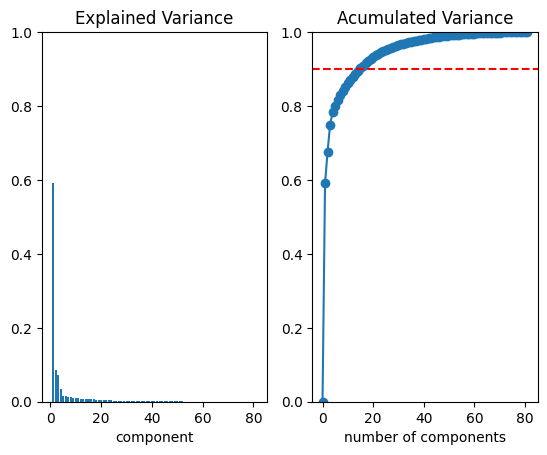

In [51]:
pca2 = PCA()

pca2.fit(x2)

explained_var2 = pca2.explained_variance_ratio_
cv2 = np.cumsum(explained_var2)
id_components2 = np.arange(1, pca2.n_components_ + 1)

fig2, axis2 = plt.subplots(1, 2)

axis2[0].bar(id_components2, explained_var2)
axis2[0].set(xlabel="component", title="Explained Variance", ylim=(0.0, 1.0))

axis2[1].plot(np.r_[0, id_components2], np.r_[0, cv2], marker="o")
axis2[1].set(
    xlabel="number of components",
    title="Acumulated Variance",
    ylim=(0.0, 1.0),
)
axis2[1].axhline(0.9, linestyle="--", color="red")

plt.show()

In [52]:
print(f'The number of PCs to obtain a variance higher than 0.9 is: {len(cv2)-sum(cv2>0.9)}')

The number of PCs to obtain a variance higher than 0.9 is: 14


To obtain an accumulated variance greater than 0.9, we need to use `COMP_NUM2=14`, in this case.

### Linear Regresion with PCA

In [53]:
COMP_NUM2 = 14

linear_regression_pca2 = make_pipeline(
    MaxAbsScaler(),
    PCA(COMP_NUM2),
    LinearRegression(),
)

linear_regression_pca2.fit(x_train2, y_train2)
y_linear_regression_pca2 = linear_regression_pca2.predict(x_test2)
rmse_linear_regression_pca2 = mean_squared_error(y_linear_regression_pca2, y_test2, squared=False)

print(f'The RMSE of the linear regression using PCA was: {rmse_linear_regression_pca2:.3f}')

The RMSE of the linear regression using PCA was: 1.678


### Linear Regression without PCA

In [57]:
linear_regression2 = make_pipeline(
    MaxAbsScaler(),
    LinearRegression()
)

linear_regression2.fit(x_train2, y_train2)
y_linear_regression2 = linear_regression2.predict(x_test2)
rmse_linear_regression2 = mean_squared_error(y_linear_regression2, y_test2, squared=False)

print(f'The RMSE of the linear regression without using PCA was: {rmse_linear_regression2:.3f}')

The RMSE of the linear regression without using PCA was: 1.607


### Random Forest with PCA

Tuning hyperparameters:

In [58]:
random_forest2 = RandomForestRegressor(random_state=SEED)

grid_random_forest2 = {
    'max_depth': [None, 3, 4, 5, 6],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_leaf_nodes': [None, 10, 20, 30]
}

search_random_forest2 = RandomizedSearchCV(
    random_forest2,
    grid_random_forest2,
    n_iter=ITER_NUM,
    cv=FOLD_NUM,
    scoring="neg_root_mean_squared_error",
    refit=True,
    n_jobs=4,
    random_state=SEED
)

search_random_forest2.fit(x_train2, y_train2)
best_params_random_forest2 = search_random_forest2.best_params_

print('The best hyperparameter found were:')
print(best_params_random_forest2)
print()
print(f'The best model had a RMSE of: {-search_random_forest2.best_score_:.3f}')

The best hyperparameter found were:
{'min_samples_leaf': 2, 'max_leaf_nodes': None, 'max_depth': None}

The best model had a RMSE of: 0.904


In [59]:
random_forest_otimized_pca2 = make_pipeline(
    MaxAbsScaler(),
    PCA(COMP_NUM2),
    RandomForestRegressor(
        max_depth = best_params_random_forest2['max_depth'],
        min_samples_leaf = best_params_random_forest2['min_samples_leaf'],
        max_leaf_nodes = best_params_random_forest2['max_leaf_nodes'],
        random_state=SEED
    )
)

random_forest_otimized_pca2.fit(x_train2, y_train2)
y_random_forest_pca2 = random_forest_otimized_pca2.predict(x_test2)
rmse_random_forest_pca2 = mean_squared_error(y_random_forest_pca2, y_test2, squared=False)

print(f'The RMSE of the random forest with PCA was: {rmse_random_forest_pca2:.3f}')

The RMSE of the random forest with PCA was: 1.248


### Random Forest without PCA

In [60]:
random_forest_otimized2 = make_pipeline(
    MaxAbsScaler(),
    RandomForestRegressor(
        max_depth = best_params_random_forest2['max_depth'],
        min_samples_leaf = best_params_random_forest2['min_samples_leaf'],
        max_leaf_nodes = best_params_random_forest2['max_leaf_nodes'],
        random_state=SEED
    )
)

random_forest_otimized2.fit(x_train2, y_train2)
y_random_forest2 = random_forest_otimized2.predict(x_test2)
rmse_random_forest2 = mean_squared_error(y_random_forest2, y_test2, squared=False)

print(f'The RMSE of the random forest without PCA was: {rmse_random_forest2:.3f}')

The RMSE of the random forest without PCA was: 0.941


## Results and Discussion

In [63]:
print(f'The linear regression model obtained performances in case 1 of: {rmse_linear_regression1:.3f} without PCA and {rmse_linear_regression_pca1:.3f} with PCA')
print(f'The linear regression model obtained performances in case 2 of: {rmse_linear_regression2:.3f} without PCA and {rmse_linear_regression_pca2:.3f} with PCA')
print()
print(f'The random forest model obtained performances in case 1 of: {rmse_random_forest1:.3f} without PCA and {rmse_random_forest_pca1:.3f} with PCA')
print(f'The random forest model obtained performances in case 2 of: {rmse_random_forest2:.3f} without PCA and {rmse_random_forest_pca2:.3f} with PCA')

The linear regression model obtained performances in case 1 of: 1.607 without PCA and 1.635 with PCA
The linear regression model obtained performances in case 2 of: 1.607 without PCA and 1.678 with PCA

The random forest model obtained performances in case 1 of: 0.941 without PCA and 1.154 with PCA
The random forest model obtained performances in case 2 of: 0.941 without PCA and 1.248 with PCA


 First, we can observe that both the linear regression and random forest models obtained almost the same performance in cases 1 and 2. This reflects that the electronegativity of the atoms did not bring any new information to the prediction of the band gap values of the materials.

 Another fact that we can highlight is that all models worsened after the dimensionality reduction made after the PCA. The linear models lost little performance, however, the random forests worsened their performance a lot after the PCA. This may mean that the loss of information during the dimensionality reduction negatively affected the models, perhaps due to the way the dataset was built. However, a curious fact is that in case 1, we need 30 PCs to obtain 90% of total variance of the initial features, while in case 2 we need only 14 PCs, that is, in some way the electronegativity may have helped to group more information after the PCA.

   Finally, we can see that the random forest model was the best model, regardless of the case or the use or not of PCA, in relation to the linear models.

## Conclusion

After the analysis of the results, we conclude that given the models and strategies used, the electronegativity of the atoms did not improve the prediction of the band gap values of the materials. We also conclude that the relationship of the molar proportion (together or not with the electronegativity) of the chemical elements present in a material is better predicted by the random forest model.

   For future work we could explore other features that influence the band gap of a material, which would add more information to the random forest models. Another point that could be explored is the difference in accumulated variance after the PCA of the two cases, and explore if in case the electronegativity of the atoms could not be used in another way in these models. We could also train some neural network for this task.

Finally, even though our hypothesis were very simple and the results not that great, we learned a lot about a ML project pipeline.

## References

- https://hackingmaterials.lbl.gov/matminer/ (documentation for `matminer`)
-  https://pymatgen.org/ (documentation for `pymatgen`)
-    https://pypi.org/project/mendeleev/ (documentation for `mendeleev`)
- https://hackingmaterials.lbl.gov/matminer/dataset_summary.html#expt-gap (page of the `expt_gap` dataset)
-        https://pt.wikipedia.org/wiki/It%C3%A9rbio (electronegativity of `Yb`)
-        https://pt.wikipedia.org/wiki/T%C3%A9rbio (electronegativity of `Tb`)
-        https://en.wikipedia.org/wiki/Europium (electronegativity of `Eu`)
-        https://pt.wikipedia.org/wiki/Prom%C3%A9cio (electronegativity of `Pm`)

